# CAR DATASET
This dataset contains some information about cars. The problem is a multiclass classification, with 4 classes. Attributes are all expressed as categorical values, but there exists some kind of order relationship between each value of the dataset

In [1]:
import pandas as pd
import os
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option("display.precision", 2)
pd.set_option("display.max.columns", None)

In [3]:
DATASET_PATH = os.path.join("datasets", "car.csv")
names = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "Classes"]
df = pd.read_csv(DATASET_PATH,delimiter=";", header=0, names=names)
df = df.convert_dtypes()
TARGET_INDEX = df.shape[1] -1

In [4]:
print("Number of rows: {}\nShape: {}".format(len(df), df.shape))
print("The columns are {}".format(list(df.columns)))

Number of rows: 1728
Shape: (1728, 7)
The columns are ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'Classes']


In [5]:
for column in df.columns:
    column_df = df[column]
    print("{}\n".format(column_df.value_counts()))

vhigh    432
high     432
med      432
low      432
Name: buying, dtype: Int64

vhigh    432
high     432
med      432
low      432
Name: maint, dtype: Int64

2        432
3        432
4        432
5more    432
Name: doors, dtype: Int64

2       576
4       576
more    576
Name: persons, dtype: Int64

small    576
med      576
big      576
Name: lug_boot, dtype: Int64

low     576
med     576
high    576
Name: safety, dtype: Int64

unacc    1210
acc       384
good       69
vgood      65
Name: Classes, dtype: Int64



The values attributes of the dataset are well balanced, while the classes are heavily unbalanced. It will be very hard to find a good classifier for *good* and *vgood* values, since they are just 69. However, with randomized trees, we can inforce a division and force every leaf to contain a different class.


## Dataset manipulation
The values of every attribute is categorical, however a logical ordering can be found. For example, low is lower than mid, which is lower than high. This can be enforced using a LabelEncoder.

In [6]:
# dictionary converting ordinal categories to values
cost_dict = {"low":0, "med":1, "high":2, "vhigh":3}
doors_dict = {"2":2, "3":3, "4":4, "5more":5}
persons_dict = {"2":2, "4":4, "more":5}
dimension_dict = {"small":0, "med":1, "big":2}
#buying
df["buying"] = df["buying"].apply(lambda x : cost_dict[x])
df["maint"] = df["maint"].apply(lambda x: cost_dict[x])
df["doors"] = df["doors"].apply(lambda x: doors_dict[x])
df["persons"] = df["persons"].apply(lambda x: persons_dict[x])
df["lug_boot"] = df["lug_boot"].apply(lambda x: dimension_dict[x])
df["safety"] = df["safety"].apply(lambda x: cost_dict[x])
classes_encoder = preprocessing.LabelEncoder().fit(df["Classes"])
df["Classes"] = classes_encoder.transform(df["Classes"])

In [7]:
"""g = sns.PairGrid(df, hue="Classes")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()"""

'g = sns.PairGrid(df, hue="Classes")\ng.map_diag(sns.histplot)\ng.map_offdiag(sns.scatterplot)\ng.add_legend()'

<AxesSubplot:>

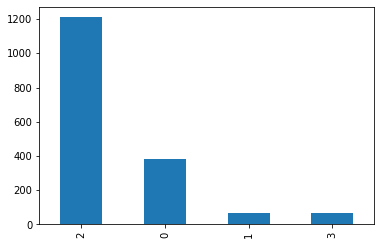

In [8]:
df["Classes"].value_counts().plot(kind="bar")

## Costruzione albero
Since the number of classes is 4 and the number of leaves is 4, they can be directly assigned to the leaves of the tree. A naive version could assign randomly the leaves and see the performances. The idea is to l

Prove per vedere come funziona il clustering

In [9]:
from sklearn.cluster import KMeans, AgglomerativeClustering,SpectralClustering, Birch
import numpy as np

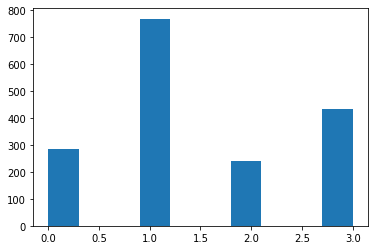

In [10]:
clustering_estimators = []
SEED = 1234
X = df[list(df.columns)[:-1]]
y = df["Classes"]
params = dict(n_clusters=4, random_state=SEED)
kmeans = KMeans(**params)
kmeans = kmeans.fit(X, sample_weight=np.zeros(len(df)))
plt.hist(kmeans.labels_)
clustering_estimators.append(kmeans)

[2 2 2 ... 1 1 1]


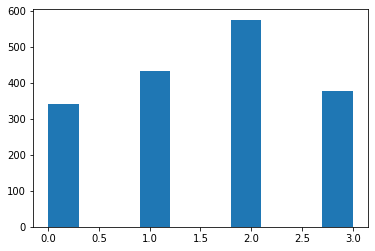

In [11]:
params = dict(n_clusters=4, random_state=SEED, assign_labels="discretize", gamma=1)
spectral = SpectralClustering(**params)
spectral = spectral.fit(X)
print(spectral.labels_)
plt.hist(spectral.labels_)
clustering_estimators.append(spectral)

[1 1 1 ... 0 3 2]
1150


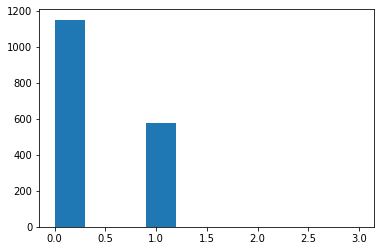

In [12]:
params = dict(n_clusters=4, linkage="single")
agglomerate = AgglomerativeClustering(**params)
agglomerate = agglomerate.fit(X)
plt.hist(agglomerate.labels_)
print(agglomerate.labels_)
print(len(agglomerate.labels_[(agglomerate.labels_==0)]))
clustering_estimators.append(agglomerate)

/home/oscarpindaro/miniconda3/envs/decision_trees/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but Birch was fitted with feature names
  warnings.warn(


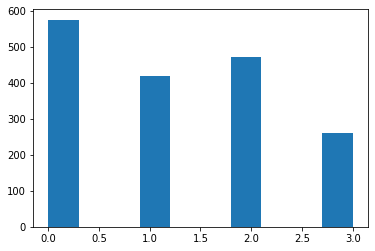

In [13]:
params = dict(n_clusters=4)
birch = Birch(**params)
birch = birch.fit(X)
plt.hist(birch.labels_)
clustering_estimators.append(birch)

## Evaluation

In [17]:
from src.cluster import find_best_estimator, recursive_best_completeness

ImportError: cannot import name 'recursive_best_completeness' from 'src.cluster' (/home/oscarpindaro/git_projects/optimization-project/src/cluster.py)

In [15]:
clustering_estimators

[KMeans(n_clusters=4, random_state=1234),
 SpectralClustering(assign_labels='discretize', gamma=1, n_clusters=4,
                    random_state=1234),
 AgglomerativeClustering(linkage='single', n_clusters=4),
 Birch(n_clusters=4)]

In [16]:
from sklearn.metrics import rand_score, adjusted_rand_score, homogeneity_score, completeness_score

true_values = df["Classes"]
f = completeness_score
for estimator in clustering_estimators:

    print(estimator.__class__.__name__, f(true_values, estimator.labels_))

IndentationError: expected an indented block (2473809783.py, line 7)

In [ ]:
truth = [0,0,1,1,2,2,2]
labelling = [0,0,0,0,1,1,1]
print("homogeneity: {}".format(homogeneity_score(truth, labelling )))
print("completeness {}".format(completeness_score(truth, labelling)))

In [ ]:
estimator = find_best_estimator(clustering_estimators, homogeneity_score, y)
print("The best estimato is {}".format(estimator))

In [ ]:
print(estimator.__class__.__name__,recursive_best_completeness([], list(range(4)), estimator.labels_, y))

In [ ]:
np.unique(estimator.labels_)

In [ ]:
el = estimator.labels_

In [ ]:
el = list(el)
el[(el==1) or (el == 3)] = 0

In [ ]:
a = [1,2,3]
a[True]

In [ ]:
import math
heigth = math.log(8,2)
n_regressors = 2**heigth -1
print(n_regressors)